#### All the necessary module imports:

In [351]:
import pandas as pd
import numpy as np
import requests 
from zipfile import ZipFile 
import io
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#matplotlib.style.use('ggplot')

#### Load the dataset from the UCI archive:
It's a zipped folder named _CCPP_ and contains the data in an excel file with xlsx format split into 5 sheets. I load it using pd.read_excel:

In [352]:
request = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip')
zipfile = ZipFile(io.BytesIO(request.content))
df = pd.read_excel(zipfile.open('CCPP/Folds5x2_pp.xlsx'), sheetname=None)

We get a dictionary of 5 DataFrames. Let's print out the type and length of df to confirm:

In [353]:
print(type(df))
print(len(df))

<class 'dict'>
5


We can check the names and verify that the dictionary contains DataFrames:

In [354]:
for key in df.keys():
    print(key, ' - ', type(df[key]))

Sheet1  -  <class 'pandas.core.frame.DataFrame'>
Sheet2  -  <class 'pandas.core.frame.DataFrame'>
Sheet3  -  <class 'pandas.core.frame.DataFrame'>
Sheet5  -  <class 'pandas.core.frame.DataFrame'>
Sheet4  -  <class 'pandas.core.frame.DataFrame'>


Next, I create a single DataFrame by stacking the abovementioned 5 DataFrames together:

In [355]:
df2 = pd.DataFrame(np.vstack((df[key] for key in df.keys())), columns=df['Sheet1'].columns)

Let's check the total number of observations in the new dataset and print out the top and bottom 5 observations:

In [356]:
print('The total number of observations is: {}'.format(len(df2)))
print()
print(df2.head())
print()
print(df2.tail())

The total number of observations is: 47840

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

          AT      V       AP     RH      PE
47835  28.27  66.56  1007.36  55.99  433.52
47836  21.89  58.62  1016.15  74.59  450.05
47837   3.20  41.31   997.67  98.84  489.86
47838  17.79  43.52  1020.65  68.29  458.57
47839  14.70  48.60  1006.91  85.65  460.63


Below we can see some descriptive information for the data:

In [357]:
df2.describe()

,AT,V,AP,RH,PE
count,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452162,12.707362,5.938535,14.599658,17.066281
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


Let's graph the __Power Output__ (__PE__), which we're trying to predict, against the predictors:

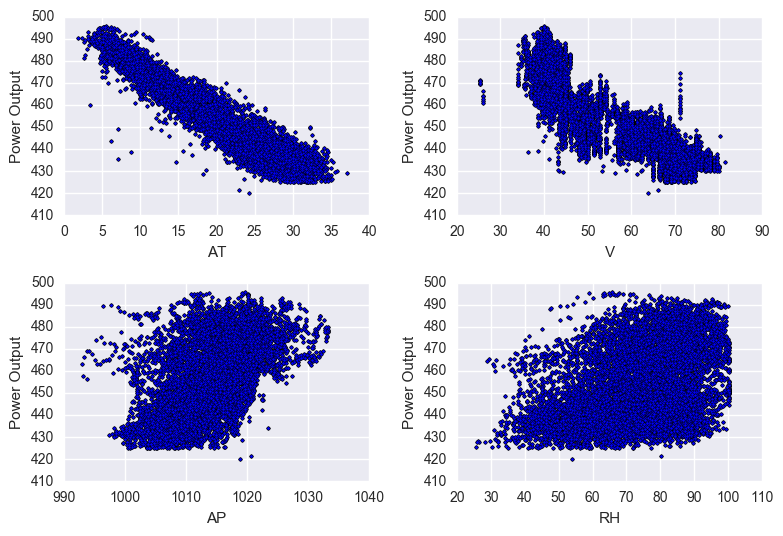

In [358]:
plt.clf()
sns.set_style("dark")
plt.figure(1, size=(9, 15))
for subplot, col in zip(range(221, 225), df2.columns):
    plt.subplot(subplot)
    plt.scatter(df2[col], df2['PE'], marker='.')
    plt.xlabel(col)
    plt.ylabel('Power Output')
    plt.grid()
plt.tight_layout()
plt.show()

From the graphs above, it looks like there's a linear relationship between __PE__ and __AT__, as well as __PE__ and __V__. There doesn't seem to be any linear relationship between __PE__ and the other two features.

## Splitting the dataset

We know that __PE__ is the dependent variable (y) and the first four columns contain the predictors.

Let's split the data into training and test sets. The training set will be used to train (and also crossvalidate) the model(s) and the test set will be used to evaluate the performance of the model(s) with unseen data.

In [359]:
X, y = df2.iloc[:,:4], df2.iloc[:, -1:]
print(X.head())
print()
print(y.head())
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      AT      V       AP     RH
0  14.96  41.76  1024.07  73.17
1  25.18  62.96  1020.04  59.08
2   5.11  39.40  1012.16  92.14
3  20.86  57.32  1010.24  76.64
4  10.82  37.50  1009.23  96.62

       PE
0  463.26
1  444.37
2  488.56
3  446.48
4  473.90


The dimensions of the training and test datasets are as shown below:

In [360]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38272, 4)
(9568, 4)
(38272, 1)
(9568, 1)


## Predictive analysis

Let's see how an OLS regression (without any regularization) would perform.
I use a pipeline to, first, standardize all the variables for a better model fit, and then to fit the Linear Regression model.
Since there are more than one predictors, it is wise to use the Adjusted R-squared value to evaluate the model performance instead of the (unadjusted) R-Squared. I calculate the Root Mean Squared Error (RMSE) and the R-Squared value as well:

In [361]:
pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipeline.fit(X_train, y_train)
predicted_y_test = pipeline.predict(X_test)

def adjusted_r2(r2, n, p):
    ''' Returns the Adjsted R-Squared value (float)
        Inputs:
            r2 - (float) R-squared of the model
            n  - (integer) sample size
            p  - (integer) number of predictors in the model
    '''
    adj_r2 = r2 - (1 - r2) * (p / (n - p - 1))
    return adj_r2

# 10-fold cross-validated RMSE and R-Squared
rmse_cv = np.sqrt(-cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=10)) 
r2_cv = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=10)
adj_r2_cv = adjusted_r2(r2=r2_cv.mean(), n=X_train.shape[0] / 10, p=X_train.shape[1])

rmse_test = np.sqrt(mean_squared_error(y_test, predicted_y_test))
r2_test = r2_score(y_test, predicted_y_test)
adj_r2_test = adjusted_r2(r2=r2_test, n=X_test.shape[0], p=X_test.shape[1])

print('The mean crossvalidated (using the training set) RMSE and its standard deviation are {:.3f} and {:.3f}'
      .format(rmse_cv.mean(), rmse_cv.std()))
print('The mean crossvalidated (using the training set) R-Squared value is {:.5f}'.format(r2_cv.mean()))
print('The mean crossvalidated (using the training set) Adjusted R-Squared value is {:.5f}'.format(adj_r2_cv))
print('\n', 'Model performance on unseen data:')
print('The test dataset RMSE is {:.3f}'.format(rmse_test))
print('The test dataset R-Squared value is {:.3f}'.format(r2_test))
print('The test dataset Adjusted R-Squared value is {:.3f}'.format(adj_r2_test))

The mean crossvalidated (using the training set) RMSE and its standard deviation are 4.566 and 0.085
The mean crossvalidated (using the training set) R-Squared value is 0.92843
The mean crossvalidated (using the training set) Adjusted R-Squared value is 0.92835

 Model performance on unseen data:
The test dataset RMSE is 4.522
The test dataset R-Squared value is 0.930
The test dataset Adjusted R-Squared value is 0.930


The adjusted R-squared is $0.93$, so the predictors in the model are able to explain quite a big proportion of the variance in the target variable. (Since the number of observations is big and the number of predictors is quite small, the R-squared and the Adjusted R-squared values are similar.) The test data RMSE is slightly smaller than the one for training data. The model actually performed a bit better with unseen data.

It is a sound strategy to always check the residuals graphically via a residuals plot. We can verify whether there is any severe non-linearity or outliers in the data:

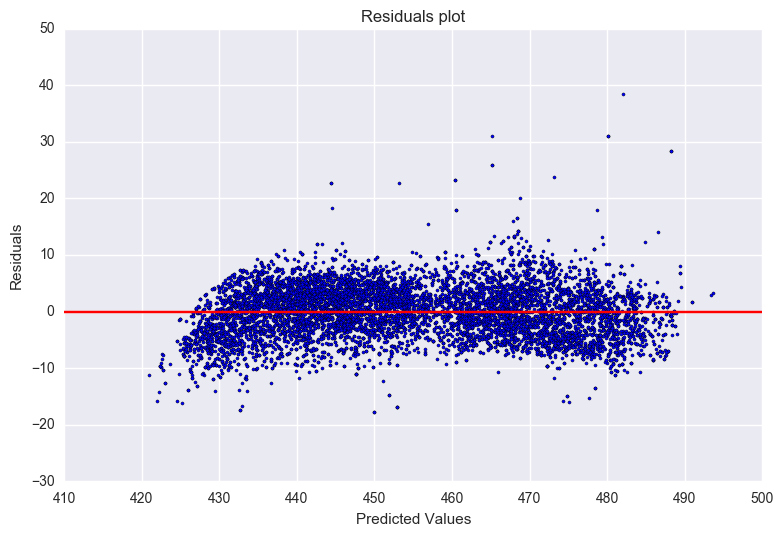

In [362]:
resids = predicted_y_test.reshape(len(y_test), 1) - y_test

plt.clf()
plt.scatter(predicted_y_test, resids, s=5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals plot')
plt.hlines(y=0, xmin=410, xmax=500, color='red')
plt.grid()
plt.tight_layout()
plt.xlim([410, 500])
plt.show()

We do not see any deviations from normality judging from the plot above. The residuals seems to be proportionately distributed around the zero (red line). There are also a few outliers.

We can plot a histogram to see the proportion of data within 2 RMSE, which should be around 95% for a normally distributed data.

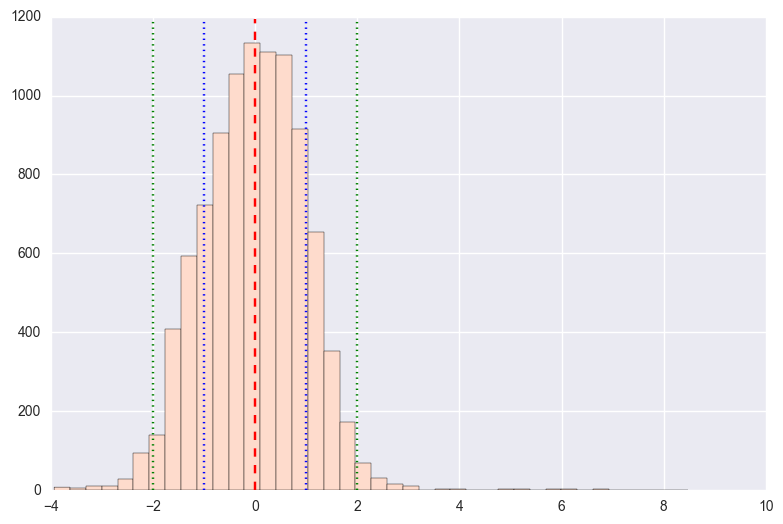

The proportion of test data predictions within 2 RMSE: 0.96


In [363]:
within_rmse = resids / rmse_test
plt.clf()
within_rmse.hist(bins=40)
plt.ylim([0, 1200])
plt.tight_layout()
plt.title('')
plt.vlines(0, ymin=0, ymax=1195, colors='r', linestyles='dashed')
plt.vlines(1, ymin=0, ymax=1195, colors='b', linestyles='dotted')
plt.vlines(-1, ymin=0, ymax=1195, colors='b', linestyles='dotted')
plt.vlines(2, ymin=0, ymax=1195, colors='g', linestyles='dotted')
plt.vlines(-2, ymin=0, ymax=1195, colors='g', linestyles='dotted')
plt.show()

count1 = within_rmse.where((within_rmse < -2) | (within_rmse > 2)).count()
print('The proportion of test data predictions within 2 RMSE: {:.2f}'.format((len(y_test) - int(count1)) / len(y_test)))

96% of the predicted values are within 2 RMSE. However, we do see some skewness, which could be a cause for concern.

Now, let's run a Ridge Regression (regression with $l_2$-regularization) and a Lasso Regression ($l_1$-regularization). I use GridSearchCV to find the best value of te parameter _alpha_ for the model using 5 folds and 7 different options for the parameter.

First, to make things easier, I define a function that will train a model and print out the model performance evaluation:

In [364]:

def tune_model(estimator, param_names, param_vals=list(np.logspace(-4, 2, 7)), y_train=y_train):
    ''' Inputs:
        estimator: Estimator, model instance
        param_names: A list of parameter names to be tuned by grid search
        param_vals: A list of parameter values to use for tuning, default(list(np.logspace(-4, 2, 7)))
        y_train: The target variable. A DataFrame or ndarray object
    '''
    if not isinstance(param_vals[0], list):
        temp_pv = []
        temp_pv.append(param_vals)
    else:
        temp_pv = param_vals
    #pipe = Pipeline([('scaler', StandardScaler()), estimator])
    params = {name: val for name, val in zip(param_names, temp_pv)}  
    grid_search = GridSearchCV(estimator, params, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0, cv=5)
    grid_search.fit(X_train, y_train)
    predicted_y_test = grid_search.predict(X_test)

    print('The score (lowest MSE) of the best model: {:.3f}'.format(np.sqrt(-grid_search.best_score_)))
    print('Best parameters: {}'.format(grid_search.best_params_))

    rmse_test = np.sqrt(mean_squared_error(y_test, predicted_y_test))
    r2_test = r2_score(y_test, predicted_y_test)
    adj_r2_test = adjusted_r2(r2=r2_test, n=X_test.shape[0], p=X_test.shape[1])

    print('\n', 'Model performance on unseen data:')
    print('The test dataset RMSE is: {:.3f}'.format(rmse_test))
    print('The test dataset R-Squared value is: {:.3f}'.format(r2_test))
    print('The test dataset Adjusted R-Squared value is {:.3f}'.format(adj_r2_test))

In [365]:
print('Ridge Regression:')
pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(random_state=1))])
tune_model(pipe, ['ridge__alpha'])

Ridge Regression:
The score (lowest MSE) of the best model: 4.567
Best parameters: {'ridge__alpha': 0.10000000000000001}

 Model performance on unseen data:
The test dataset RMSE is: 4.522
The test dataset R-Squared value is: 0.930
The test dataset Adjusted R-Squared value is 0.930


In [366]:
print('Lasso Regression:')
pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(random_state=1))])
tune_model(pipe, ['lasso__alpha'])

Lasso Regression:
The score (lowest MSE) of the best model: 4.567
Best parameters: {'lasso__alpha': 0.0001}

 Model performance on unseen data:
The test dataset RMSE is: 4.522
The test dataset R-Squared value is: 0.930
The test dataset Adjusted R-Squared value is 0.930


As we can see, the results are the same as using the OLS model without any regularization. Both, the lasso and ridge regression perform equally.

Since a Decision Tree model is better for non-linear data, let's see how it performs.
An advantage of Decision Tree models is that we don't need to transform the features, so no need for standardization here.

In [367]:
dt = DecisionTreeRegressor(random_state=1, max_depth=5)
score = np.sqrt(-cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv=10))
print('The mean crossvalidated (using the training set) RMSE is {:.3f}'.format(score.mean()))

The mean crossvalidated (using the training set) RMSE is 4.336


Let's try to tune the maximum depth of the tree using the tune_model function I defined earlier. Below I try the values 2, 3 and 5 as the max_depth parameter value and print out the MSE and the best parameter it corresponds to. Then I predict using the test data with the best found parameters and print out the model performance for that prediction:

In [368]:
print('Decision Tree model:')
dt = DecisionTreeRegressor(random_state=1)
tune_model(dt, ['max_depth'], [2, 3, 5])

Decision Tree model:
The score (lowest MSE) of the best model: 4.340
Best parameters: {'max_depth': 5}

 Model performance on unseen data:
The test dataset RMSE is: 4.329
The test dataset R-Squared value is: 0.935
The test dataset Adjusted R-Squared value is 0.935


So, with a maximum depth equal to 5, the Decision Tree model above performs slightly better than the Linear Regression models before it.

We can try a Random Forest model, which is an ensemble of Decision Tree models and as such has better generalization potential.

In [369]:
forest = RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=1,
                               warm_start=1, oob_score=1, max_depth=8)
score = np.sqrt(-cross_val_score(forest, X_train, y_train.values.ravel(), scoring='neg_mean_squared_error', cv=5))
print('The mean crossvalidated (using the training set) RMSE is {:.3f}'.format(score.mean()))

forest.fit(X_train, y_train.values.ravel())
predicted_y_test = forest.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, predicted_y_test))
r2_test = r2_score(y_test, predicted_y_test)
adj_r2_test = adjusted_r2(r2=r2_test, n=X_test.shape[0], p=X_test.shape[1])

print('\n', 'Model performance on unseen data:')
print('The test dataset RMSE is: {:.3f}'.format(rmse_test))
print('The test dataset R-Squared value is: {:.2f}'.format(r2_test))
print('The test dataset Adjusted R-Squared value is {:.2f}'.format(adj_r2_test))

The mean crossvalidated (using the training set) RMSE is 3.338

 Model performance on unseen data:
The test dataset RMSE is: 3.322
The test dataset R-Squared value is: 0.96
The test dataset Adjusted R-Squared value is 0.96


With max depth equal to 8 and 30 decision trees in the ensemble, the Random Forest model is better than just a sinle Decision Tree.

Let's try to tune the $n\_estimators$ and $max\_depth$ parameters:

In [370]:
print('Random Forest model:')
tune_model(forest, ['n_estimators', 'max_depth'], [[30, 70, 100], [3, 6, 10]], y_train.values.ravel())

Random Forest model:
The score (lowest MSE) of the best model: 2.705
Best parameters: {'max_depth': 10, 'n_estimators': 100}

 Model performance on unseen data:
The test dataset RMSE is: 2.664
The test dataset R-Squared value is: 0.976
The test dataset Adjusted R-Squared value is 0.976


We can see that the tuned Random Forest model above is able to perform better than the other earlier models (which weren't performing so bad to begin with). We are able to get the RMSE value down to 2.664 and the Adjusted R-Squared value up to almost 0.98 in the test dataset.